In [74]:
import random
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras import models
from tensorflow.keras import layers

BATCH_SIZE = 32
IMG_SIZE = 224

TRAIN_DIR = './data/pre/train_images/'
TEST_DIR = './data/pre/test_images/'
ROOT_DIR = './data/pre/'
MODELS_DIR = './Models'

TRAIN_DF = pd.read_csv('./data/pre/train.csv')
TEST_DF = pd.read_csv('./data/pre/test.csv')

CNTS = np.array([[1443, 362],
                 [295, 75],
                 [799, 200],
                 [154, 39],
                 [235, 60]])

In [51]:
def GetSingleClass(df,c,n):
    lx = (df['class'] == c) & (df['type'] == 0)
    res = list(df[lx]['filename'].to_numpy())
    if lx.sum() > n:
        return res[:n]
    m = n - lx.sum()
    lx = (df['class'] == c) & (df['type'] != 0)
    lst = list(df[lx].sort_values(by='type')['filename'].to_numpy())
    res += lst[:m]
    return res
    
def GetClassesElements(df,cv,nv):
    res = []
    for i in range(len(cv)):
        res += GetSingleClass(df,cv[i],nv[i])
    return res
        
def GetGenerator(df,cv,nv,rootdir,bs = 32):
    fv1 = GetClassesElements(df,cv[0],nv[0])
    fv2 = GetClassesElements(df,cv[1],nv[1])
    df = pd.DataFrame({'filename' : fv1 + fv2, 'class' : ['0']*len(fv1) + ['1']*len(fv2)})
    for i in range(100):
        df = df.sample(frac = 1).reset_index(drop=True)
    gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
    tr_gen = gen.flow_from_dataframe(df,target_size = (IMG_SIZE, IMG_SIZE),directory = rootdir,
                                     class_mode = 'binary', batch_size = bs) 
    return tr_gen

def SaveModel(model,name):
    path = os.path.join(MODELS_DIR,name)
    for suf in [''] + [str(i) for i in range(256)]:
        modified_path = path + suf
        if not os.path.exists(modified_path):
            os.makedirs(modified_path)
            path = modified_path
            break
    model.save(path)
    return path

def draw_evolution(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [89]:
train_batch_size = 128
train_set = [[1],[2,3,4]]
train_cnts = [[1188], [799,154,235]]
train_cnt = np.array([x for y in train_cnts for x in y]).sum()
train = GetGenerator(TRAIN_DF,train_set,train_cnts, TRAIN_DIR,bs = train_batch_size)

test_batch_size = 64
test_set = [[1],[2,3,4]]
test_cnts = [[75], [25,25,25]]
test_cnt = np.array([x for y in test_cnts for x in y]).sum()
test = GetGenerator(TEST_DF,test_set,test_cnts, TEST_DIR,bs = test_batch_size)

eval_set = [[1],[2,3,4]]
eval_cnts = [[75], [200,39,60]]
eval_cnt = np.array([x for y in test_cnts for x in y]).sum()
eval_gen = GetGenerator(TEST_DF,test_set,test_cnts, TEST_DIR,bs = 64)

Found 2376 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


In [83]:
name_of_model = 'Model_5_GlobAve_512_0005_ep40'

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 256)      

In [ ]:
start = time.time()
history = model.fit(train,
                    steps_per_epoch = train_cnt//train_batch_size,
                    epochs = 5,
                    validation_data = test,
                    validation_steps = test_cnt//test_batch_size)
elapsed_time = time.time() - start
print(elapsed_time)

Train for 18 steps, validate for 2 steps
Epoch 1/5
18/18 [==============================] - 181s 10s/step - loss: 0.0265 - accuracy: 0.9893 - val_loss: 0.9837 - val_accuracy: 0.7422
Epoch 2/5
 1/18 [>.............................] - ETA: 4:44 - loss: 0.0047 - accuracy: 1.0000

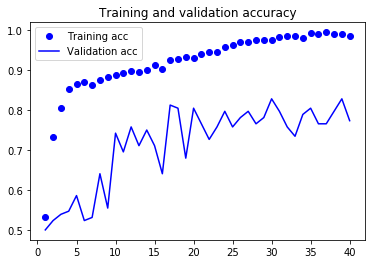

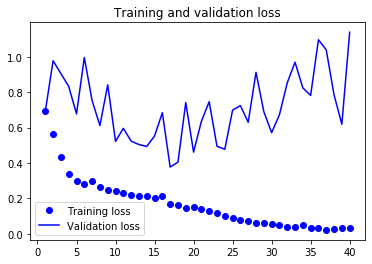

In [85]:
draw_evolution(history)

In [86]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.4203 - accuracy: 0.7667


[1.4203194975852966, 0.76666665]

In [88]:
name_of_model = 'Model_5_Flat_Dr05_512_0005_ep40_bch64_acc76_LT2h'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_Flat_Dr05_512_0005_ep40_bch64_acc76_LT2h\assets


'./Models\\Model_5_Flat_Dr05_512_0005_ep40_bch64_acc76_LT2h'